# Time Series Data Forecasting with QGANs

In [470]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [518]:
import datetime
import time
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [519]:
wires = range(15)
dev = qml.device('default.qubit', wires=wires)

In [520]:
data = np.load('data/prices_15_4.npy', allow_pickle=True)

In [521]:
msft_data = data[0]
msft_b = msft_data[0]
msft_f = msft_data[1]

In [522]:
def flatten(data):
    in_one_arr = []
    for i in range(19):
        if i <= 14:
            in_one_arr.append(data[0][i])
        elif i >=15:
            in_one_arr.append(data[1][i-15])
    return np.reshape(in_one_arr, (1,1,19))

## Structure of QGAN

### Generator — parameterized quantum circuit

In [523]:
@qml.qnode(dev, interface="tf")
def gen_circuit(b_seq, gen_weights):
    # Embedding past time series onto circuit
    qml.templates.AngleEmbedding(b_seq, wires, rotation='X')
    
    # Adjusting parameters of generator ansatz
    qml.broadcast(unitary=qml.RY, pattern = 'single', wires = wires, parameters = gen_weights[0:15])
    for k in range(1, int(len(gen_weights)) // 15):
        qml.broadca
        st(unitary=qml.CZ, pattern = 'ring', wires=wires)
        qml.broadcast(unitary=qml.RY, pattern = 'single', wires = wires, parameters = gen_weights[(15*k):(15*(k+1))])
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

In [524]:
def generator(equity_data, gen_weights):
    generated_prices =  gen_circuit(equity_data[0], gen_weights).numpy()
    return [equity_data[0], gen_circuit(equity_data[0], gen_weights).numpy()]

In [525]:
init_gen_weights = tf.Variable(np.random.normal(0, 1, 15))

#### Testing generator and gradients of generator

In [526]:
generator(msft_data, init_gen_weights)

[array([-1.        ,  0.68858394, -0.71996818,  0.64508565,  0.12111897,
         0.84157581,  0.8777076 ,  0.22345133, -0.30409296, -0.18410706,
         0.        , -0.8391851 ,  0.06801392,  0.02368372,  0.0141945 ]),
 array([0.46836688, 0.00559263, 0.46434005, 0.24259269])]

In [527]:
gen_circuit(msft_data[0], init_gen_weights)

<tf.Tensor: shape=(4,), dtype=float64, numpy=array([0.46836688, 0.00559263, 0.46434005, 0.24259269])>

In [528]:
with tf.GradientTape() as tape:
    res = gen_circuit(msft_data[0], init_gen_weights)
grad = tape.gradient(res, init_gen_weights)
print(grad)

tf.Tensor(
[-0.26936786  0.77212636  0.59129664 -0.76133234  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ], shape=(15,), dtype=float64)


### Discriminator — classical CNN

In [529]:
def make_discrim():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=[1, 19]))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu'))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    return model

In [530]:
discriminator = make_discrim()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1, 16)             320       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 16)             272       
_________________________________________________________________
dense_10 (Dense)             (None, 1, 128)            2176      
_________________________________________________________________
dense_11 (Dense)             (None, 1, 1)              129       
Total params: 2,897
Trainable params: 2,897
Non-trainable params: 0
_________________________________________________________________


## Training

### Loss — real is 1, fake is 0

In [531]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    """Calculating loss"""
    return cross_entropy(np.ones_like(fake_output), fake_output)

In [532]:
def discriminator_loss(fake_output, real_output):    
    """Compute discriminator loss.""" 
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Optimizer — Adam

In [533]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### One train step

In [534]:
BATCH_SIZE=256

def train_step(equity_data, gen_weights):
    """Run train step on provided image batch."""
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape: 
        generated_prices = tf.concat([equity_data[0], gen_circuit(equity_data[0], gen_weights)], 0)
        generated_prices = tf.reshape(generated_prices, (1,1,19))

        real_prices = tf.concat([equity_data[0], equity_data[1]], 0)
        real_prices = tf.reshape(real_prices, (1,1,19))
        """Getting outputs from discrim"""
        real_output = discriminator(real_prices)
        fake_output = discriminator(generated_prices)

        """Calculating loss"""
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    print(f"Generator loss: {gen_loss} \n Discriminator loss: {disc_loss}")
    gradients_of_generator = gen_tape.gradient(gen_loss, gen_weights)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip([gradients_of_generator], [gen_weights]))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, gen_weights

In [535]:
init_gen_weights

<tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
array([ 0.52192557, -1.56355331, -0.90508874,  1.26232546, -0.7493758 ,
        0.56009356, -1.02414739, -0.08734031, -0.44967353,  1.60362236,
       -0.05913132, -0.02008548,  1.06564651,  1.03896621, -0.30832588])>

In [536]:
train_step(msft_data, tf.Variable(init_gen_weights))

Generator loss: 0.712684154510498 
 Discriminator loss: 1.3834013938903809


(<tf.Tensor: shape=(), dtype=float32, numpy=0.71268415>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.3834014>,
 <tf.Variable 'Variable:0' shape=(15,) dtype=float64, numpy=
 array([ 0.52182568, -1.56365327, -0.90518873,  1.26222552, -0.7493758 ,
         0.56009356, -1.02414739, -0.08734031, -0.44967353,  1.60362236,
        -0.05913132, -0.02008548,  1.06564651,  1.03896621, -0.30832588])>)

### Visualizing training process

In [465]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [466]:
# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

In [468]:
EPOCHS = 5
visgen_weights = init_gen_weights

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}")
    gen_loss, disc_loss, visgen_weights = train_step(msft_data, visgen_weights)
        
    with file_writer.as_default():
        tf.summary.scalar('gen_loss', gen_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)
    
    # Reset metrics every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Epoch 1
Generator loss: 0.11164283007383347 
 Discriminator loss: 0.16651295125484467
Epoch 2
Generator loss: 0.11103152483701706 
 Discriminator loss: 0.16562409698963165
Epoch 3
Generator loss: 0.11045683920383453 
 Discriminator loss: 0.16473866999149323
Epoch 4
Generator loss: 0.10989206284284592 
 Discriminator loss: 0.16385594010353088
Epoch 5
Generator loss: 0.10933192074298859 
 Discriminator loss: 0.1629711091518402


In [473]:
%tensorboard --logdir tb_logs/

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 22464.

## Visualizing results

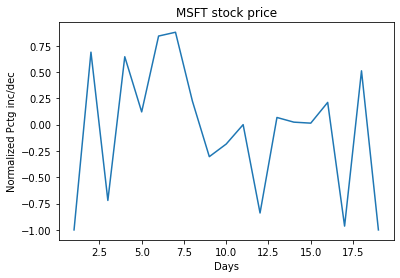

In [447]:
days =  np.arange(1, 20)
real_stats = np.append(msft_data[0], msft_data[1])
plt.plot(days, real_stats)
plt.title("MSFT stock price")
plt.xlabel("Days")
plt.ylabel("Normalized Pctg inc/dec")
plt.show()

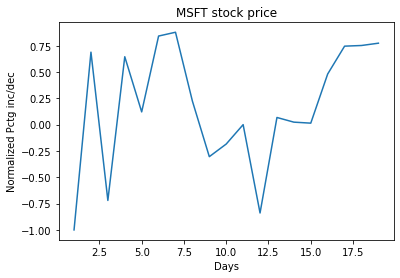

In [446]:
b_days = np.arange(1,20)
fake_stats = tf.concat([msft_data[0], gen_circuit(msft_data[0], gen_weights)], 0).numpy()
plt.plot(b_days, fake_stats)
plt.title("MSFT stock price")
plt.xlabel("Days")
plt.ylabel("Normalized Pctg inc/dec")
plt.show()

<hr>

### Visualizing training process

In [370]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

In [ ]:
def train(dataset, epochs, start_epoch=1):
    """Launch full training run for given number of epochs."""
        
    batched_data = tf.data.Dataset.from_tensor_slices(dataset).shuffle(N_SAMPLES).batch(512)
    t = time.time()
    for epoch in range(start_epoch, start_epoch + epochs):
        for i, image_batch in enumerate(batched_data):
            # Log batch-wise loss.
            gl, dl = train_step(image_batch)
            tf.summary.scalar(
                'Generator loss', data=gl, step=epoch * len(batched_data) + i)
            tf.summary.scalar(
                'Discriminator loss', data=dl, step=epoch * len(batched_data) + i)

        # Log full dataset XEB Fidelity and generated distribution.
        generated_samples = generator(tf.random.normal([N_SAMPLES, 100]))
        tf.summary.scalar(
        'Generator XEB Fidelity Estimate', data=xeb_fid(generated_samples), step=epoch)
        tf.summary.histogram(
        'Generator distribution', data=bits_to_ints(generated_samples), step=epoch)
        # Log new samples drawn from this particular random circuit.
        random_new_distribution = generate_data(REFERENCE_CIRCUIT, N_SAMPLES)
        tf.summary.histogram(
        'New round of True samples', data=bits_to_ints(random_new_distribution), step=epoch)

        if epoch % 10 == 0:
            print('Epoch {}, took {}(s)'.format(epoch, time.time() - t))
            t = time.time()